In [1]:
# ! wget https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
# ! pip install git+https://github.com/facebookresearch/sam2.git

In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

checkpoint = "sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))


image_url = 'https://plus.unsplash.com/premium_photo-1664298004972-af1ad3b52321?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8YnJvd24lMjBiZWFyfGVufDB8fDB8fHww'
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

/opt/conda/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


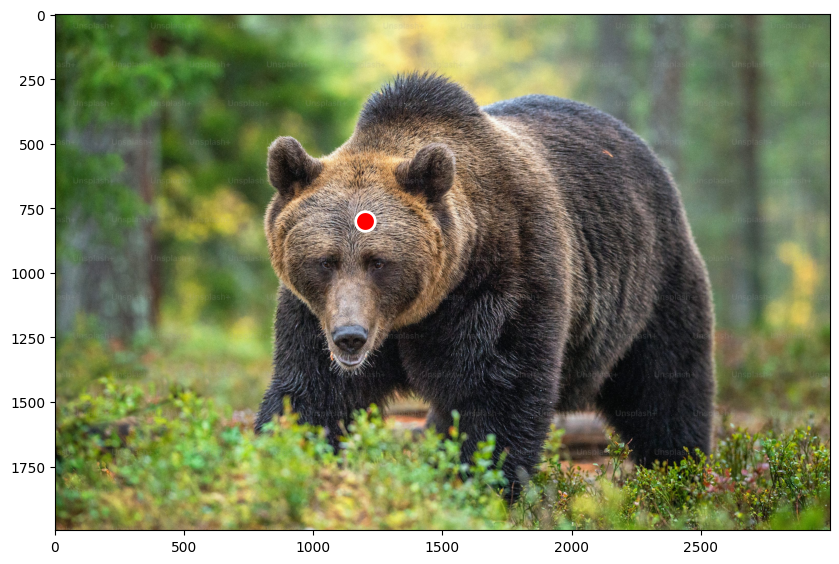

In [3]:
input_point = np.array([[1200, 800]])   
input_label = np.array([1]) 

img = np.array(image)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(input_point[0, 0], input_point[0, 1], color='red', marker='o', s=200, edgecolor='white', linewidth=2)
plt.axis('on')
plt.show()

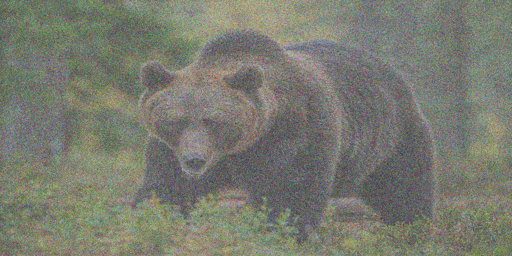

In [37]:
# Convert image to NumPy array
image_np = np.array(image)

# Generate Gaussian noise
mean = 0
stddev = 300 
noise = np.random.normal(mean, stddev, image_np.shape)

# Add noise to the image
corrupted_image = np.clip(image_np + noise, 0, 255).astype(np.uint8)

corrupted_image = Image.fromarray(corrupted_image)
corrupted_image.resize((512,256))

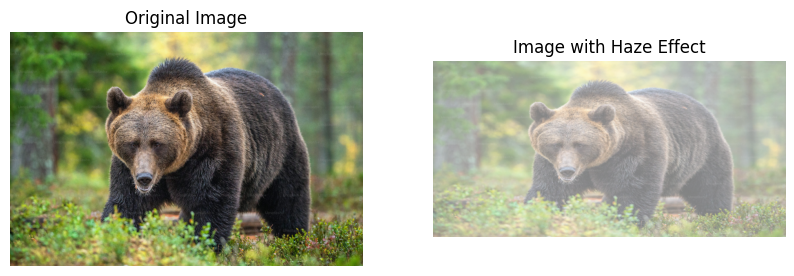

In [32]:
from PIL import ImageEnhance

def apply_haze(image_np, haze_factor=0.4, haze_color=[255, 255, 255]):
    haze_layer = np.full(image_np.shape, haze_color, dtype=np.uint8)
    haze_image = np.clip((1 - haze_factor) * image_np + haze_factor * haze_layer, 0, 255).astype(np.uint8)
    return Image.fromarray(haze_image)

image_np = np.array(image)
corrupted_image = apply_haze(image_np, haze_factor=0.5)
haze_image_for = corrupted_image.resize((512, 256))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(haze_image_for)
plt.title("Image with Haze Effect")
plt.axis('off')
plt.show()

In [43]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(corrupted_image)
    masks, _, _ = predictor.predict(input_point, input_label)

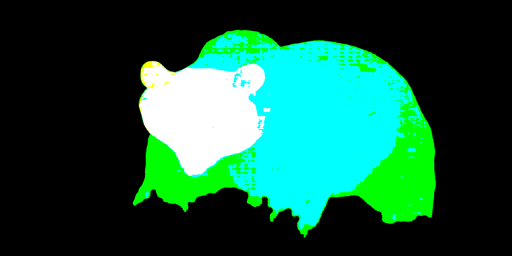

In [34]:
import numpy as np
from PIL import Image

masks_uint8 = (masks.transpose(1, 2, 0) * 255).astype(np.uint8)
mask_image = Image.fromarray(masks_uint8)
mask_image.resize((512,256))

In [50]:
np.unique(masks_uint8)

array([  0, 255], dtype=uint8)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image_np = np.array(image)
mask = masks

unique_segments = np.unique(masks)

colors = plt.cm.get_cmap('hsv', len(unique_segments))

overlay = np.zeros((*image_np.shape[:2], 3), dtype=np.uint8)

for i, segment in enumerate(unique_segments):
    if segment == 0:
        continue
    overlay[masks[0] == segment] = (colors(i)[:3] * 255).astype(np.uint8)

alpha = 0.5
combined_overlay = np.clip((1 - alpha) * image_np + alpha * overlay, 0, 255).astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(combined_overlay)
plt.title("Image with Segmented Mask Overlay")
plt.axis('off')
plt.show()

/tmp/ipykernel_11029/1825227379.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_segments))


AttributeError: 'tuple' object has no attribute 'astype'

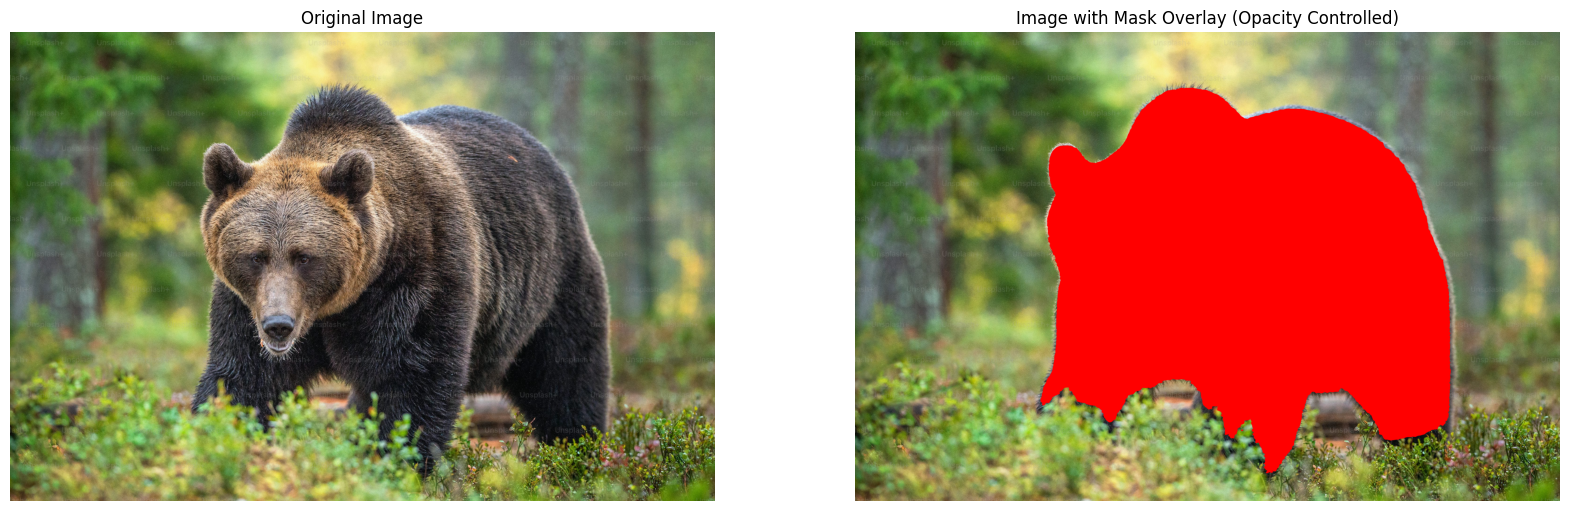

In [40]:
image_np = np.array(image)
mask = (masks.transpose(1, 2, 0) * 255).astype(np.uint8)

threshold = 1
opacity = 0
binary_mask = np.where(np.mean(mask, axis=-1) > threshold, 1.0, opacity)  

# Set the color for the mask overlay (red here)
mask_color = np.array([255, 0, 0])  # Red mask color

# Use alpha blending to mix the mask with the image based on opacity
overlay = (binary_mask[..., None] * mask_color + (1 - binary_mask[..., None]) * image_np).astype(np.uint8)

# Plot the original image and the overlay with opacity
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Image with Mask Overlay (Opacity Controlled)")
plt.axis('off')

plt.show()